In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm
import pandas as pd
import numpy as np
import os

from glob import glob
from datetime import datetime
from matplotlib.patches import  Polygon
from matplotlib.collections import PatchCollection

from utils import fileio
from utils import visualise
from utils import geometry
from utils import matrices
from source import segmentation_hand

In [3]:
def make_polygon(i, C, R, cell_centres):
    """
    Generate polygon

    Parameters:
    i (int): cell id
    C (numpy array): Nc x Nv order array relating cells to vertices
    R (numpy array): vertex coordinates
    cell_centres (numpy array): cell centre coordinates
    """

    Ralpha=R[np.where(C[i,:]==1)[0]]-cell_centres[i] #ref frame of cell
    ang=np.arctan2(Ralpha[:,1], Ralpha[:,0])%(2*np.pi) #find angle with x axis
    R_ang=np.transpose(np.vstack((np.where(C[i,:]==1)[0], ang))) #stack index of vertices with angle
    ordered_vertices=R_ang[np.argsort(R_ang[:,-1], axis=0)] #sort by anticlockwise angle
    polygon = Polygon(R[ordered_vertices[:,0].astype(int)],closed = True)
    return polygon

def plot_edges(A, R):
    N_e=np.shape(A)[0]
    beg_edge = ((abs(A) - A)*0.5)@R
    end_edge = ((abs(A) + A)*0.5)@R
    for j in range(0,N_e):
        if (beg_edge[j,0]!=0) and (end_edge[j, 0]!=0):
            plt.plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],'k',alpha=1.0,linestyle ='-')

def plot_cell_centres(cell_centres):
    for i in range(len(cell_centres)):
        plt.plot(cell_centres[i,0],cell_centres[i,1],'k',marker ='o',markersize=1)
        
def plot_cell_id(cell_centres):
    for i in range(len(cell_centres)):
        plt.text(cell_centres[i][0], cell_centres[i][1], str(i),fontsize= 7,color='w', horizontalalignment='center', verticalalignment='center')

def plot_alignment_axis(cell_centres,alignment_axis):
    for i in range(len(cell_centres)):
            plt.quiver(cell_centres[i,0],cell_centres[i,1],np.cos(alignment_axis)[i],np.sin(alignment_axis)[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)
            plt.quiver(cell_centres[i,0],cell_centres[i,1],-np.cos(alignment_axis)[i],-np.sin(alignment_axis)[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)



def plot_polys(C, R, cell_centres):
    N_c=np.shape(C)[0]
    patches = []

    for i in range(N_c):
        polygon = make_polygon(i, C, R, cell_centres)
        patches.append(polygon)

    p = PatchCollection(patches,alpha = 1.0)
    return p

def plot_binary_polys(C, R, cell_centres, plot_var, threshold):
    N_c=np.shape(C)[0]
    patches = []
    patchesLow = []
    patchesHigh = []

    for i in range(N_c):
        polygon = make_polygon(i, C, R, cell_centres)
        patches.append(polygon)
        
        if plot_var[i] < threshold:
            polygonLow = polygon
            patchesLow.append(polygonLow)
        else:
            polygonHigh = polygon
            patchesHigh.append(polygonHigh)


    ### For binary effective pressure
    p_low = PatchCollection(patchesLow,alpha = 0.5)
    p_high = PatchCollection(patchesHigh,alpha = 0.7)
   
    return p_low, p_high


In [4]:
def new_matrices(A,B,C,R, edge_verts, cell_edges, all_cells,cell_id):
    ce=[cell_edges[x] for x in cell_id.astype(int)]
    cells=[all_cells[x] for x in cell_id.astype(int)]

    cell_edge_count=geometry.get_edge_count(B)
    cell_centres=geometry.get_cell_centres(C,R,cell_edge_count)
    cc=np.array([cell_centres[x] for x in cell_id.astype(int)])

    vertices=np.unique([x for sublist in cells for x in sublist]).astype(int)
    edges=np.unique([x for sublist in ce for x in sublist]).astype(int)

    edge_verts=edge_verts[sorted(edges)]
    R_new=R[sorted(vertices)]

    Nv=len(vertices)
    Ne=len(edges)
    #re index  and edges
    nodes=sorted(vertices)
    new_nodes=np.linspace(0,len(vertices)-1, len(vertices)).astype(int)
    node_map = {nodes[i]: new_nodes[i] for i in range(len(new_nodes))}

    edges=sorted(edges)
    new_edges=np.linspace(0,len(edges)-1, len(edges)).astype(int)
    edge_map = {edges[i]: new_edges[i] for i in range(len(new_edges))}


    edge_verts[:,0]=[node_map[x] for x in edge_verts[:,0]]
    edge_verts[:,1]=[node_map[x] for x in edge_verts[:,1]]

    new_cells=[[node_map[x] for x in sublist]for sublist in cells]
    new_cell_edges=[[edge_map[x] for x in sublist]for sublist in ce]

    new_A,new_B,new_C,new_R=matrices.get_matrices(edge_verts, R_new, new_cell_edges, cc[:,0], cc[:,1])

    ce_new=geometry.get_edge_count(new_B)
    cc_new=geometry.get_cell_centres(new_C,new_R,ce_new)

    return new_A, new_B, new_C, new_R, cc_new





In [5]:
def plot_cmap(plot_variable, cmap, save_dir, stretch, frame,title, c_label, A,B,C,R, cc ):
    #plot_variable=cell_circ_0 ###Set variable to plot

    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})

    ## For colormap of continuous data
    polys=plot_polys(C, R, cc)
    polys.set_facecolor('black')
    ax.add_collection(polys) 

    polys=plot_polys(C, R, cc)
    #polys.set_facecolor('black')
    polys.set_array(plot_variable)
    polys.set_cmap(cmap) ###set polygon colourmap here
    polys.set_clim(-np.max(abs(plot_variable)), np.max(abs(plot_variable)))
    ax.add_collection(polys) 
    cbar = fig.colorbar(polys, ax=ax)
    cbar.ax.set_ylabel(c_label, rotation=90) ###set colorbar label




    ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    plot_edges(A, R)

    #plot_cell_id(cc)

    ax.set_title(title) ###change title
    plt.gca().set_aspect('equal')
    plt.tight_layout()

    ##uncomment to save
    plt.savefig(save_dir+'/'+title+'.png', dpi=300)

In [7]:
def reindex_data(o_folder, save_dir,stretch, frame, pixel_size, micron_size, stg_pos, cell_id):
    mat_dir=glob(o_folder+'\\20230126_2_IN_CheHis-BFPCAAX_uf_'+ stretch + '_MP_fr'+frame+'\\*\\Matrices')[0]
    tr_dir=glob(o_folder+'\\20230126_2_IN_CheHis-BFPCAAX_uf_'+ stretch + '_MP_fr'+frame+'\\*\\Trace_extraction')[0]
    A  = np.loadtxt(glob(mat_dir+'/*Matrix_A*.txt')[0]) # Incidence matrix. Rows => edges; columns => vertices.
    B  = np.loadtxt(glob(mat_dir+'/*Matrix_B*.txt')[0]) # Incidence matrix. Rows => cells; columns => edges.
    C  = np.loadtxt(glob(mat_dir+'/*Matrix_C*.txt')[0]) # Incidence matrix. Rows => cells; columns => vertices. 
    R  = np.loadtxt(glob(mat_dir+'/*Matrix_R*.txt')[0]) # Coordinates of vertices

    edge_verts  = np.loadtxt(glob(tr_dir+'/*edge_verts.csv')[0]).astype(int)
    c_edges = cellEdges = pd.read_csv(glob(tr_dir+'/*cell_edges.csv')[0],header =None, delimiter=',', names=list(range(13))).dropna(axis='columns', how='all')
    cell_edges={}
    for i in range(len(c_edges)):
        cell_edges[i]=np.asarray(cellEdges.iloc[i].dropna())

    
    all_cells=[]
    for i in range(len(C)):
        all_cells.append(np.where(C[i,:]!=0)[0])

    R=R*(micron_size/pixel_size)
    #R=R+stg_pos*10

    #save_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230203_incremental'

    A_new,B_new,C_new,R_new,cc=new_matrices(A,B,C,R, edge_verts, cell_edges, all_cells,cell_id)
    #fileio.write_matrices(save_dir+'/Matrices',A_new, B_new, C_new,R_new, "20230203_1_us_"+stretch+"_fr"+frame+"_track")

    return A_new, B_new, C_new, R_new, cc



In [16]:
o_folder='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Code\\tissue_image_analysis\\tissue_image_analysis\\Output'
#folders=glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Code\\tissue_image_analysis\\tissue_image_analysis\\Output\\20230203_1_IN_BFPCAAX-CheHis_us_*\\*')
cell_map=np.loadtxt('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230126\\20230126_map_0_300.csv', delimiter=',',skiprows=1 )
stage_pos=np.loadtxt('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Iona_Movies\\Instant\\20230126_Instant_m3c3\\20230126_stagepos.csv', delimiter=',',skiprows=1 )
save_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230126'
pref_area_f='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Code\\tissue_image_analysis\\tissue_image_analysis\\Output\\20230203_1_IN_BFPCAAX-CheHis_us_0p5_SP_fr1\\2023-06-29_18-37-43\\Data\\20230203_1_IN_BFPCAAX-CheHis_us_0p5_SP_fr1_pref_area.txt'
with open(pref_area_f,"r") as f:
        pref_area=float(f.readline())
pixel_size=1024
micron_size=554.11



In [19]:
A_0, B_0, C_0, R_0, cc_0=reindex_data(o_folder, save_dir,'0p5', '1', pixel_size, micron_size, stage_pos[0, -2:], cell_map[:,0])
cell_areas_0=geometry.get_areas(A_0, B_0, R_0)
cec_0=geometry.get_edge_count(B_0)
circ_0,maj_shape_axis_0,shape_axis_0=geometry.get_shape_tensor(R_0,C_0,cec_0,cc_0, [])

A_300, B_300, C_300, R_300, cc_300=reindex_data(o_folder, save_dir,'8p6', '01', pixel_size, micron_size, stage_pos[1, -2:], cell_map[:,1])
cell_areas_300=geometry.get_areas(A_300, B_300, R_300)
cec_300=geometry.get_edge_count(B_0)
circ_300,maj_shape_axis_300,shape_axis_300=geometry.get_shape_tensor(R_300,C_300,cec_300,cc_300, [])

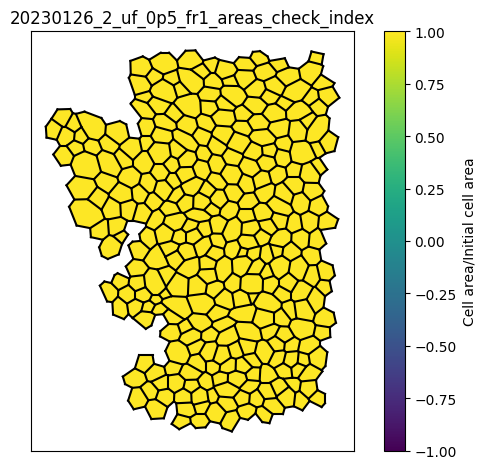

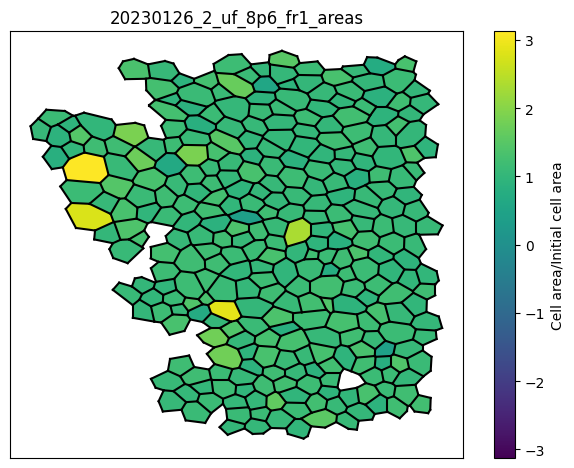

In [20]:
cmap='viridis'
label='Cell area/Initial cell area'
plot_cmap(cell_areas_0/cell_areas_0, cmap,save_dir, '0p5', '1', "20230126_2_uf_0p5_fr1_areas_check_index", label, A_0, B_0, C_0, R_0, cc_0)
plot_cmap(cell_areas_300/cell_areas_0, cmap,save_dir, '8p6', '1', "20230126_2_uf_8p6_fr1_areas", label, A_300, B_300, C_300, R_300, cc_300)


In [14]:
area_change=cell_areas_300-cell_areas_0
circ_change=circ_300-circ_0

In [19]:
visualise.angle_hist(shape_axis_0, 'Shape_Axis_alignment', save_dir, 12, 180, '20230126_2_uf_0p5_fr1')
visualise.angle_hist(shape_axis_300, 'Shape_Axis_alignment', save_dir, 12, 180, '20230126_2_uf_8p6_fr1')

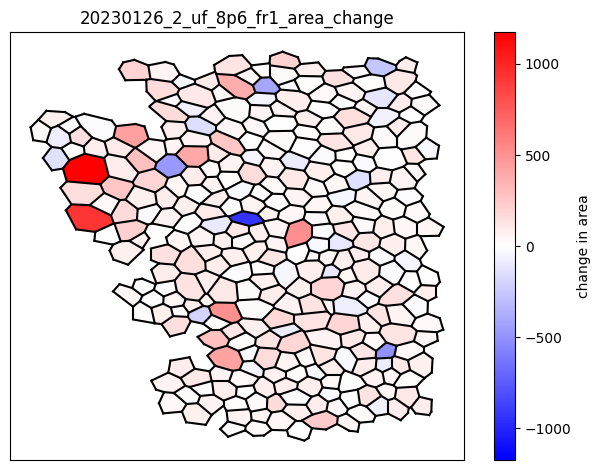

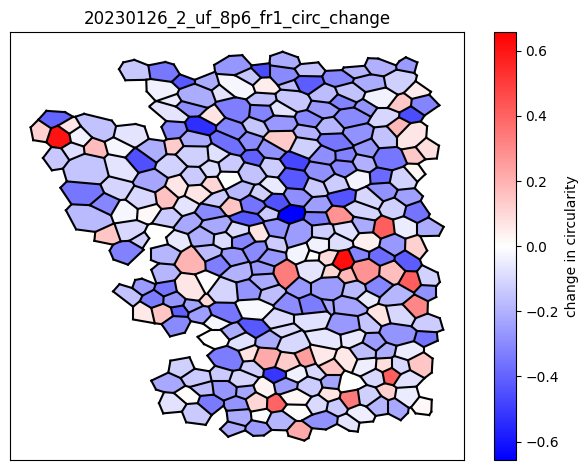

In [15]:
plot_cmap(area_change, 'bwr',save_dir, '8p6', '1', "20230126_2_uf_8p6_fr1_area_change", 'change in area', A_300, B_300, C_300, R_300, cc_300)
plot_cmap(circ_change, 'bwr',save_dir, '8p6', '1', "20230126_2_uf_8p6_fr1_circ_change", 'change in circularity', A_300, B_300, C_300, R_300, cc_300)
